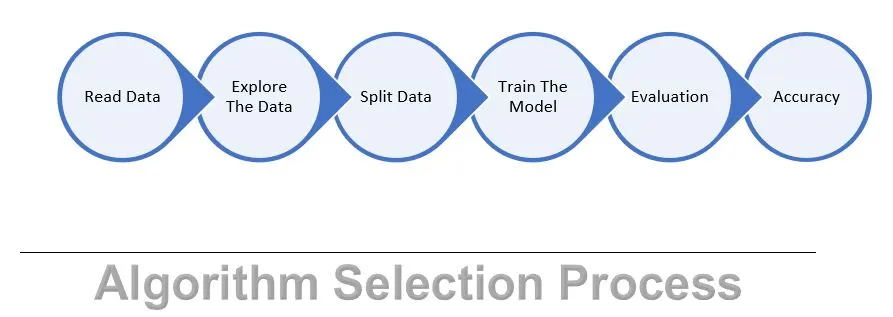

source: https://medium.com/analytics-vidhya/standardscaler-and-normalization-with-code-and-graph-ba220025c054

## Import needed libraries

In [130]:
import shutup; shutup.please()

In [156]:
import numpy as np
import pandas as pd
from keras.models import Sequential,load_model 
from keras.layers import Dense, Dropout
from collections import Counter
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.wrappers.scikit_learn import KerasRegressor 
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
import matplotlib.pyplot as plt

In [19]:

# class for Y convertions
class TextLabelEncoderDummy:

    def labelencoder(y_df):
        encoder = LabelEncoder()
        encoder.fit(y_df)
        encoded_Y = encoder.transform(y_df)
        return encoded_Y, encoder


    def encoded_to_dummy(encoded_Y):
        # convert encoder variable to dummy variable
        uniques, ids = np.unique(encoded_Y, return_inverse=True)
        dummy_y = to_categorical(ids, len(uniques))
        # dummy_y = np_utils.to_categorical(encoded_Y)
        return dummy_y, uniques


    def reverse_dummy_to_encoded(y_test):
        reverse_dummy = uniques[y_test.argmax(1)]
        return reverse_dummy


    def reverse_encoded_to_text(reverse_dummy):
        reverse_encoded = encoder.inverse_transform(reverse_dummy)
        return reverse_encoded

## Data Preprocessing

#### load dataset into notebook

In [7]:
df = pd.read_csv('../../../datasets/dr-nubel/strain_stress_with_target/full_strain_stress_data.csv')
df.head(2)

,strain,stress,height,tor
0,-0.0135,0.630,2.600000,184
1,0.0272,2.311,2.601381,184


In [8]:
# Checking dataset basic information like number of column and row
# this also provides information regarding if there are null(empty) entry or not
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365 entries, 0 to 2364
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   strain  2365 non-null   float64
 1   stress  2365 non-null   float64
 2   height  2365 non-null   float64
 3   tor     2365 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 74.0 KB


### Removing duplicates

In [9]:
# We will use this method to first take a transpose of our dataset as shown below:
df_T = df.T
df_T.shape

(4, 2365)

In [11]:
# Let's find the total number of duplicate features in our dataset using the sum() method, chained with the duplicated() method as shown below.
print(df_T.duplicated().sum())

0


The value zero(0) above shows there are no duplicate entry in the data

In [333]:
# unique_features = df_T.drop_duplicates(keep='first').T
# bNow, let's print the shape of our new training set without duplicate features:
# unique_features.shape

In [334]:
# duplicated_features = [dup_col for dup_col in df_T.columns if dup_col not in unique_features.columns]
# duplicated_features

### Transform data

In [134]:
# convert dataframe to numpy array
values = df.values
X, y = values[:, 0:3], values[:,3]
# X = X.reshape(len(X), 36, 1)
X = np.asarray(X).astype(np.float64)

In [135]:
X.shape,y.shape

((2365, 3), (2365,))

#### Scaling

Feature scaling is the process of normalising the range of features in a dataset. Real-world datasets often contain features that are varying in degrees of magnitude, range and units. Therefore, in order for machine learning models to interpret these features on the same scale, we need to perform feature scaling.

for more details
https://towardsdatascience.com/what-is-feature-scaling-why-is-it-important-in-machine-learning-2854ae877048#:~:text=Feature%20scaling%20is%20the%20process,need%20to%20perform%20feature%20scaling.

- For this model I used two scaling functions which are:
- StandardScaler and MinMaxScaler

Standardization: StandardScaler() standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation. Standardization can be helpful in cases where the data follows a Gaussian distribution (or Normal distribution). However, this does not have to be necessarily true. Also, unlike normalization, standardization does not have a bounding range. So, even if you have outliers in your data, they will not be affected by standardization.

where μ is the mean (average) and σ is the standard deviation from the mean; standard scores (also called z scores) of the samples are calculated as follows:

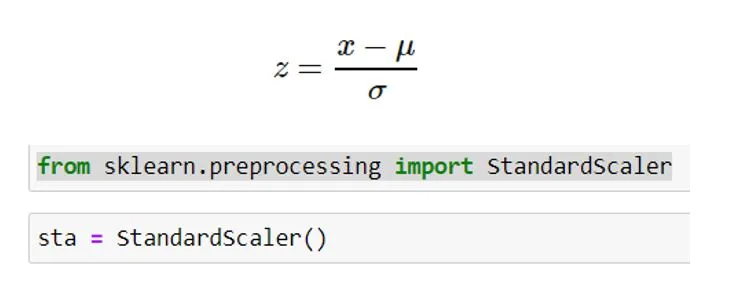

Normalization: Normalization is good to use when you know that the distribution of your data does not follow a Gaussian distribution. This can be useful in algorithms that do not assume any distribution of the data like K-Nearest Neighbors and Neural Networks. The default range for the feature returned by MinMaxScaler is 0 to 1. Note that MinMaxScaler doesn’t reduce the importance of outliers.

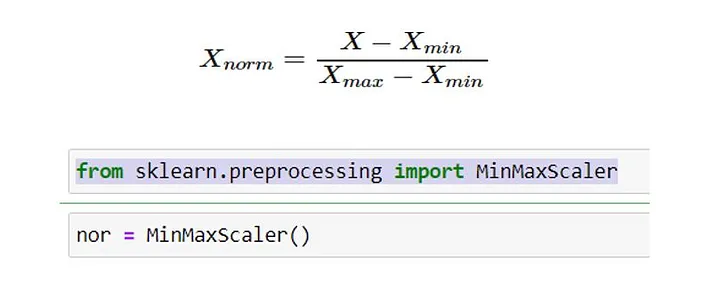


In [136]:
# Transform
scalarX, scalarY = StandardScaler(), MinMaxScaler()

In [137]:
X_transform = scalarX.fit_transform(X)

In [139]:
scalarY.fit(y.reshape(-1,1))

MinMaxScaler()

In [140]:
y_transform = scalarY.transform(y.reshape(-1,1))

In [143]:
X_transform.shape,y_transform.shape

((2365, 3), (2365, 1))

### Split data

- I splitted the data for training, evaluation and testing of the model

When you create a datasource, you can choose to split your datasource sequentially, and Amazon ML uses the first 70 percent of your data for training and the remaining 30 percent of the data for evaluation. This is the default approach when you use the Amazon ML console to split your data.

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X_transform, y_transform,test_size=0.3,random_state=42)

In [145]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,test_size=0.5,random_state=42)

In [146]:
X_train.shape

(1655, 3)

In [108]:
#create and fit the LSTM network
model = Sequential()
model.add(LSTM(17, input_shape=(look_back, 3)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=28, verbose=1)


Epoch 1/10


2023-05-17 08:54:41.825276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 08:54:41.827294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 08:54:41.828501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

60/60 [==============================] - 2s 3ms/step - loss: 0.2034
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0811
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0381
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0269
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0228
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0221
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0213
Epoch 10/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0205


In [109]:
import math
from sklearn.metrics import mean_squared_error

In [117]:
xtrain = X_train.reshape(-1,3)
xtest = X_test.reshape(-1,3)

In [115]:
X_test.shape

(355, 1, 3)

## Model Definition

#### ANN Model with KerasRegressor

In [264]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(40, input_dim=3, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(20))
    model.add(Dense(10))
    model.add(Dense(1, activation='sigmoid'))
    # model.add(Dense(1, activation='softmax'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [265]:
# save model
model = baseline_model()
model.summary()

Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_455 (Dense)           (None, 40)                160       
                                                                 
 dense_456 (Dense)           (None, 30)                1230      
                                                                 
 dense_457 (Dense)           (None, 20)                620       
                                                                 
 dense_458 (Dense)           (None, 10)                210       
                                                                 
 dense_459 (Dense)           (None, 1)                 11        
                                                                 
Total params: 2,231
Trainable params: 2,231
Non-trainable params: 0
_________________________________________________________________


In [320]:

estimator = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=10, verbose=0)
# cv = KFold(n_splits=10, shuffle=True)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
results = cross_val_score(estimator, X_train, y_train, cv=cv)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# print("Model accuracy: %.2f"% (accuracy*100))

Baseline: -0.53% (0.34%)


In [329]:
estimator.fit(X_train, y_train, verbose=0)
k_pred = estimator.predict(X_test)

yy,pp = scalarY.inverse_transform(y_test),scalarY.inverse_transform(k_pred.reshape(-1,1))
testScore = math.sqrt(mean_squared_error(yy, pp))

print('Test Score: %.2f RMSE' % (testScore))

Test Score: 21.90 RMSE


In [330]:
for i in range(len(yy)):
    print('Test -- >',yy[i],'---- predicted -- >',pp[i],'---- diff -- >',abs(yy[i]-pp[i]))
    if i == 30:
        break

Test -- > [186.] ---- predicted -- > [205.07317] ---- diff -- > [19.07316589]
Test -- > [70.] ---- predicted -- > [88.89214] ---- diff -- > [18.89214325]
Test -- > [160.] ---- predicted -- > [174.35399] ---- diff -- > [14.35398865]
Test -- > [482.] ---- predicted -- > [476.15036] ---- diff -- > [5.84963989]
Test -- > [383.] ---- predicted -- > [383.85703] ---- diff -- > [0.85702515]
Test -- > [70.] ---- predicted -- > [108.82917] ---- diff -- > [38.82917023]
Test -- > [70.] ---- predicted -- > [70.234146] ---- diff -- > [0.23414612]
Test -- > [70.] ---- predicted -- > [70.991844] ---- diff -- > [0.99184418]
Test -- > [168.] ---- predicted -- > [184.90419] ---- diff -- > [16.90419006]
Test -- > [482.] ---- predicted -- > [481.90012] ---- diff -- > [0.09988403]
Test -- > [160.] ---- predicted -- > [181.90834] ---- diff -- > [21.90834045]
Test -- > [383.] ---- predicted -- > [389.36484] ---- diff -- > [6.36483765]
Test -- > [160.] ---- predicted -- > [174.08385] ---- diff -- > [14.0838470

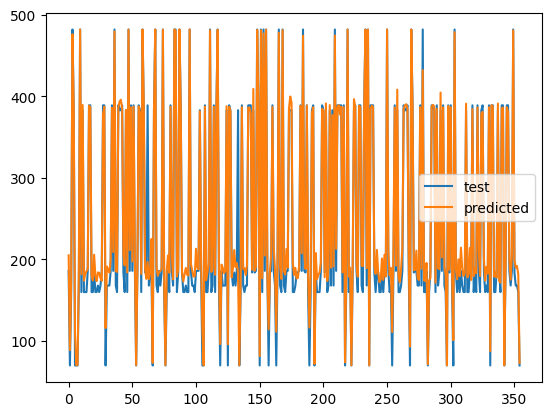

In [332]:
# plt.plot(dataset[:,3].reshape(-1,1), label='dataset')
plt.plot(yy,label='test')
plt.plot(pp,label='predicted')
plt.legend()
plt.show()

#### ANN model

In [323]:
model = baseline_model()
history = model.fit(X_train, y_train, batch_size=10, epochs=10, verbose=0, validation_split=0.33)
# create directory to save model
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb#scrollTo=Yh5Mu0yOgE5J
# model.save('saved_model/my_model')
model.save('ann.h5')

In [268]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


In [324]:
# saved_model = load_model('saved_model/my_model')
saved_model = load_model('ann.h5')
# Check its architecture
saved_model.summary()
# 4. evaluate network
score  = saved_model.evaluate(X_val, y_val, verbose=1)
# print(score)
print('Restored model,Loss: {:5.2f}%'.format(100 * score))
# 5. make predictions
predictions = saved_model.predict(X_test, verbose=1)
# print(predictions)

Model: "sequential_207"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_741 (Dense)           (None, 40)                160       
                                                                 
 dense_742 (Dense)           (None, 30)                1230      
                                                                 
 dense_743 (Dense)           (None, 20)                620       
                                                                 
 dense_744 (Dense)           (None, 10)                210       
                                                                 
 dense_745 (Dense)           (None, 1)                 11        
                                                                 
Total params: 2,231
Trainable params: 2,231
Non-trainable params: 0
_________________________________________________________________
12/12 [==============================] - 0s 2ms/st

In [325]:
#calculate root mean squared error
yy,pp = scalarY.inverse_transform(y_test),scalarY.inverse_transform(predictions)
xx=scalarX.inverse_transform(X_transform)
testScore = math.sqrt(mean_squared_error(yy, pp))
print('Test Score: %.2f RMSE' % (testScore))

In [327]:
for i in range(len(yy)):
    print('Test -- >',yy[i],'---- predicted -- >',pp[i],'---- diff -- >',abs(yy[i]-pp[i]))
    if i == 30:
        break

Test -- > [186.] ---- predicted -- > [161.63515] ---- diff -- > [24.36485291]
Test -- > [70.] ---- predicted -- > [138.64168] ---- diff -- > [68.64167786]
Test -- > [160.] ---- predicted -- > [131.13081] ---- diff -- > [28.8691864]
Test -- > [482.] ---- predicted -- > [448.10815] ---- diff -- > [33.8918457]
Test -- > [383.] ---- predicted -- > [370.7957] ---- diff -- > [12.20431519]
Test -- > [70.] ---- predicted -- > [146.63858] ---- diff -- > [76.63858032]
Test -- > [70.] ---- predicted -- > [75.22662] ---- diff -- > [5.22662354]
Test -- > [70.] ---- predicted -- > [92.68642] ---- diff -- > [22.68641663]
Test -- > [168.] ---- predicted -- > [139.2292] ---- diff -- > [28.77079773]
Test -- > [482.] ---- predicted -- > [481.4446] ---- diff -- > [0.5553894]
Test -- > [160.] ---- predicted -- > [161.97824] ---- diff -- > [1.97824097]
Test -- > [383.] ---- predicted -- > [392.98123] ---- diff -- > [9.98123169]
Test -- > [160.] ---- predicted -- > [160.05946] ---- diff -- > [0.0594635]
Test

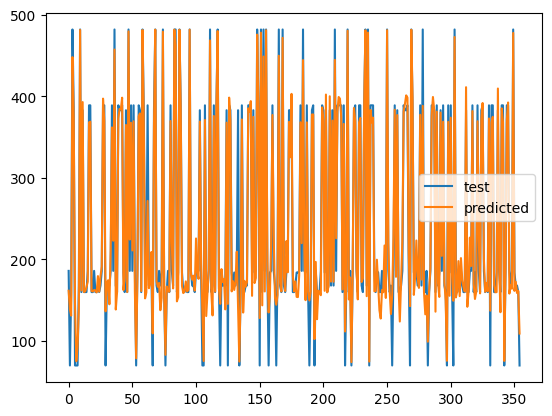

In [328]:
# plt.plot(dataset[:,3].reshape(-1,1), label='dataset')
plt.plot(yy,label='test')
plt.plot(pp,label='predicted')
plt.legend()
plt.show()

In [181]:
Counter(itertools.chain.from_iterable(scalarY.inverse_transform(y_train)))

Counter({168.0: 316,
         160.0: 315,
         389.0: 300,
         186.0: 284,
         184.0: 132,
         70.0: 123,
         482.0: 103,
         383.0: 82})

In [ ]:
# example of making predictions for a regression problem
from sklearn.datasets import make_regression
# generate regression dataset
scalarX, scalarY = MinMaxScaler(), MinMaxScaler()
scalarX.fit(X)
scalarY.fit(y.reshape(100,1))
X = scalarX.transform(X)
y = scalarY.transform(y.reshape(100,1))
# define and fit the final model
model = Sequential()
model.add(Dense(4, input_dim=2, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, epochs=1000, verbose=0)
# new instances where we do not know the answer
Xnew, a = make_regression(n_samples=3, n_features=2, noise=0.1, random_state=1)
Xnew = scalarX.transform(Xnew)
# make a prediction
ynew = model.predict(Xnew)
# show the inputs and predicted outputs
for i in range(len(Xnew)):
	print("X=%s, Predicted=%s" % (Xnew[i], ynew[i]))a